# PyMLP

A scratch class-based implementation of a multilayer perceptron in Python, geared for MNIST.

_April 16, 2017_

---

## Packages

In [1]:
# 3rd party packages
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# My MNIST loader (pip install mnist_web)
from mnist_web import mnist, render

## Load MNIST

In [2]:
def mnist_numpy(onehot_labels=False, flat_images=False):
    """Return train_images, train_labels, test_images, test_labels."""
    # Load MNIST
    train_images, train_labels, test_images, test_labels = mnist()

    if flat_images:
        train_images = np.array([np.array(img).flatten() for img in train_images])
        train_labels = np.array(train_labels)
        test_images = np.array([np.array(img).flatten() for img in test_images])
        test_labels = np.array(test_labels)
    else:
        train_images = np.array([np.array(img) for img in train_images])
        train_labels = np.array(train_labels)
        test_images = np.array([np.array(img) for img in test_images])
        test_labels = np.array(test_labels)

    if onehot_labels:
        # Cast labels to one-hot vectors
        def cast_to_one_hot(integers):
            """Return matrix whose rows are one-hot vectors for integers."""
            output = np.zeros((integers.size, integers.max() + 1))
            output[np.arange(integers.size), integers] = 1
            return output

        train_labels = cast_to_one_hot(train_labels)
        test_labels = cast_to_one_hot(test_labels)

    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = mnist_numpy(onehot_labels=True, flat_images=True)

# Activation functions

In [4]:
def plot(function):
    xs = np.arange(-5, 5, 0.01)
    ys = [function(x) for x in xs]
    dys = [function(x, deriv=True) for x in xs]

    plt.plot(xs, ys)
    plt.plot(xs, dys)
    plt.grid(True)

## Linear

In [5]:
def linear(x, labels=None, deriv=False):
    """Linear layer."""
    if deriv:
        return np.ones_like(x)
    else:
        return x

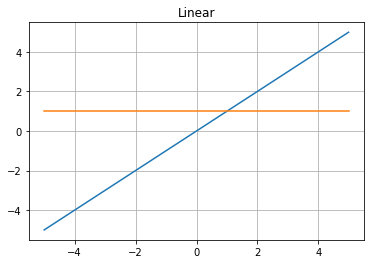

In [6]:
plt.title('Linear')
plot(linear)

## Sigmoid

In [7]:
def sigmoid(x, labels=None, deriv=False):
    """Numerically-stable sigmoid."""
    if deriv:
        z = sigmoid(x)
        return z * (1 - z)
    else:    
        if np.all(x) >= 0:
            z = np.exp(-x)
            return 1 / (1 + z)
        else:
            z = np.exp(x)
            return z / (1 + z)

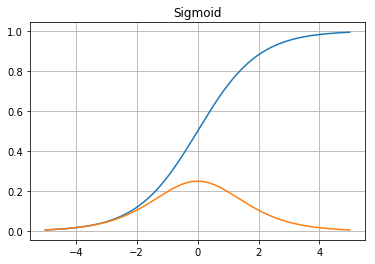

In [8]:
plt.title('Sigmoid')
plot(sigmoid)

## Hyperbolic tangent

In [9]:
def tanh(x, labels=None, deriv=False):
    """Hyperbolic tangent."""
    if deriv:
        return 1 - np.tanh(x)**2
    else:
        return np.tanh(x)

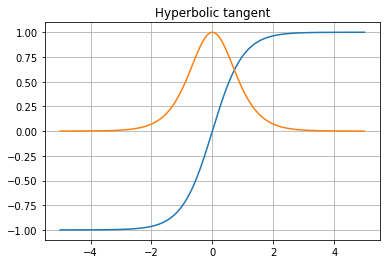

In [10]:
plt.title('Hyperbolic tangent')
plot(tanh)

## Rectified linear unit (ReLU)

In [11]:
def relu(x, labels=None, deriv=False):
    """Rectified linear unit."""
    if deriv:
        return (x > 0) * 1
    else:
        try:
            return np.maximum(x, 0, x)
        except TypeError:
            """When x is not iterable."""
            return np.maximum(x, 0)

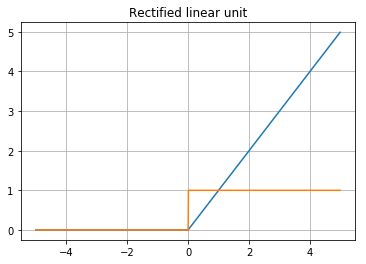

In [12]:
plt.title('Rectified linear unit')
plot(relu)

## Softmax

---

Softmax is a vector-to-vector transformation that turns an unnormalized vector

$$x = \begin{bmatrix} x_0,\ x_1,\ \dots,\ x_9 \end{bmatrix}$$

into a normalized vector

$$s(x) = \begin{bmatrix} s(x)_0,\ s(x)_1,\ \dots,\ s(x)_9 \end{bmatrix}.$$

The transformation is best described element-wise. So the $i$th output is given by

$$ s(x)_i = \frac{e^{x_i}}{\sum_{j=0}^{9} e^{x_j}}. $$

### Invariance to scaling
Softmax is invariant to additively scaling every element of $x$ by the same constant $c$.

*Proof:*

\begin{align*}
s(x + c)_i &= \frac{e^{x_i + c}}{\sum_{j=0}^{9} e^{x_j + c}}  \\
           &= \frac{e^{x_i}e^c}{\sum_{j=0}^{9} e^{x_j}e^c}    \\
           &= \frac{e^c e^{x_i}}{e^c \sum_{j=0}^{9} e^{x_j}}   \\
           &= \frac{e^{x_i}}{\sum_{j=0}^{9} e^{x_j}} = s(x)_i
\end{align*}

That means we can protect softmax from numerical overflow by subtracting the maximum entry of $x$ from every element of $x$

$$ s(x - \max(x))_i = \frac{e^{x_i - \max(x)}}{\sum_{j=0}^{9} e^{x_j - \max(x)}} = \frac{e^{x_i}}{\sum_{j=0}^{9} e^{x_j}} = s(x)_i $$

In [13]:
def softmax_matrix(matrix):
    """Return the row-wise softmax of matrix.

    :type matrix: ndarray
    :param matrix: unnormalized matrix with a row per example
    """
    def softmax_vector(vector):
        """Return the softmax of vector.

        :type vector: ndarray
        :param vector: unnormalized vector
        """
        row_sum = np.exp(vector).sum()
        return np.array([np.exp(x_i) / row_sum for x_i in vector])

    # Subtract the max of each row from each row (for stability)
    row_maxes = np.max(matrix, axis=1)
    row_maxes = row_maxes[:, np.newaxis]  # for broadcasting
    matrix = matrix - row_maxes
    
    return np.array([softmax_vector(row) for row in matrix])

### Check our softmax against TensorFlow's softmax

In [14]:
import tensorflow as tf
import numpy as np
batch = np.asarray([[1,2,3,6],[2,4,5,6],[1,2,3,6]])
x = tf.placeholder(tf.float32, shape=[None, 4])
y = tf.nn.softmax(x)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(y, feed_dict={x: batch})

Instructions for updating:
Use `tf.global_variables_initializer` instead.


array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037045],
       [ 0.01203764,  0.08894681,  0.24178252,  0.657233  ],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037045]], dtype=float32)

In [15]:
softmax_matrix(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

## Derivative of Softmax

---

Since softmax is a vector-to-vector transformation, its derivative is a Jacobian matrix. The Jacobian has a row for each output element $s(x)_i$, and a column for each input element $x_j$. The entries of the Jacobian take two forms, one for the main diagonal entry, and one for every off-diagonal entry. Here we'll show how to compute row $i$ of the Jacobian, which is the gradient of output element $s(x)_i$ with respect to each of its input elements $x_j$. We first restate the input vector, output vector, and elementwise softmax formula for clarity.

\begin{align*}
x &= \begin{bmatrix} x_0,\ x_1,\ \dots,\ x_9 \end{bmatrix} \\ \\
s(x) &= \begin{bmatrix} s(x)_0,\ s(x)_1,\ \dots,\ s(x)_9 \end{bmatrix} \\ \\
s(x)_i &= \frac{e^{x_i}}{\sum_{j=0}^{9} e^{x_j}} \\
\end{align*}

First compute the diagonal entry of row $i$ of the Jacobian, that is, compute the derivative of the $i$'th output of softmax, $s(x)_i$, with respect to its $i$'th input, $x_i$:

\begin{align*}
\frac{\partial s(x)_i}{\partial x_{i}} &= \frac{\sum_{j=0}^{9} e^{x_j} e^{x_i} - e^{x_i} e^{x_i}}{(\sum_{j=0}^{9} e^{x_j})^2} \\
&= s(x)_i - s(x)_i^2 \qquad \text{diagonal entry} \\
\end{align*}

Now compute every off-diagonal entry of row $i$ of the Jacobian, that is, compute the derivative of the $i$'th output of softmax, $s(x)_i$, with respect to its $j$'th input, $x_j$, where $j \neq i$.

\begin{align*}
\frac{\partial s(x)_i}{\partial x_{j}} &= \frac{\sum_{j=0}^{9} e^{x_j} \cdot 0 - e^{x_i} e^{x_j}}{(\sum_{j=0}^{9} e^{x_j})^2} \\
&= - s(x)_i s(x)_j \qquad \text{off-diagonal entry}
\end{align*}

The form of the off-diagonals tells us that the Jacobian of softmax is a symmetric matrix. This is nice because symmetric matrices have great numeric and analytic properties. We expand it below. Each row is a gradient of one output element with respect to each of its input elements.

\begin{equation}
J\big(s(x)\big) =
\begin{bmatrix}
    \nabla s(x)_0 \\
    \nabla s(x)_1 \\
    \nabla s(x)_2 \\
    \dots \\
    \nabla s(x)_9
\end{bmatrix}
=
\begin{bmatrix}
    s(x)_0 - s(x)_0^2 & -s(x)_0 s(x)_1 & -s(x)_0 s(x)_2 & \dots  & -s(x)_0 s(x)_9 \\
    -s(x)_1 s(x)_0 & s(x)_1 - s(x)_1^2 & -s(x)_1 s(x)_2 & \dots  & -s(x)_1 s(x)_9 \\
    -s(x)_2 s(x)_0 & -s(x)_2 s(x)_1    & s(x)_2 - s(x)_2^2 & \dots & -s(x)_2 s(x)_9 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    -s(x)_9 s(x)_0 & -s(x)_9 s(x)_1 & -s(x)_9 s(x)_2 & \dots  & s(x)_9 - s(x)_9^2 \\
\end{bmatrix}
\end{equation}

Notice that we can express this matrix as

$$\text{diag}\big(s(x)\big) - s(x)_{10 \times 1}^\top s(x)_{1 \times 10}.$$

The term on the right is the outer product since we're working with row vectors. We labeled the dimensions to be explicit.

In [16]:
def jacobian_tensor(softmaxed_matrix):
    """Return Jacobian tensor of a matrix whose rows are softmaxed.

    :type softmax_matrix: ndarray
    :param softmax_matrix: matrix whose rows are softmaxed
    """
    def jacobian_matrix(softmaxed_vector):
        """Return Jacobian matrix of a softmax vector.

        :type softmax_vector: ndarray
        :param softmax_vector: softmax distribution over classes
        """
        s = softmaxed_vector
        return np.diag(s) - np.outer(s, s)

    return np.array([jacobian_matrix(row) for row in softmaxed_matrix])

In [17]:
batch

array([[1, 2, 3, 6],
       [2, 4, 5, 6],
       [1, 2, 3, 6]])

In [18]:
softmax_matrix(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

In [19]:
jacobian_tensor(softmax_matrix(batch))

array([[[  6.22948920e-03,  -1.06822194e-04,  -2.90372829e-04,
          -5.83229418e-03],
        [ -1.06822194e-04,   1.67499567e-02,  -7.89315184e-04,
          -1.58538193e-02],
        [ -2.90372829e-04,  -7.89315184e-04,   4.41748369e-02,
          -4.30951488e-02],
        [ -5.83229418e-03,  -1.58538193e-02,  -4.30951488e-02,
           6.47812623e-02]],

       [[  1.18927379e-02,  -1.07071001e-03,  -2.91049156e-03,
          -7.91153631e-03],
        [ -1.07071001e-03,   8.10352810e-02,  -2.15057854e-02,
          -5.84587856e-02],
        [ -2.91049156e-03,  -2.15057854e-02,   1.83323732e-01,
          -1.58907455e-01],
        [ -7.91153631e-03,  -5.84587856e-02,  -1.58907455e-01,
           2.25277777e-01]],

       [[  6.22948920e-03,  -1.06822194e-04,  -2.90372829e-04,
          -5.83229418e-03],
        [ -1.06822194e-04,   1.67499567e-02,  -7.89315184e-04,
          -1.58538193e-02],
        [ -2.90372829e-04,  -7.89315184e-04,   4.41748369e-02,
          -4.30951488e-

# Put softmax into one function

In [20]:
def softmax(matrix, deriv=False):
    """Return the row-wise softmax matrix or Jacobian tensor of matrix.

    :type matrix: ndarray
    :param matrix: unnormalized matrix with a row per example
    """
    # Allow passing arrays
    if matrix.ndim == 1:
        matrix = np.array([matrix])

    if deriv:
        return jacobian_tensor(softmax_matrix(matrix))
    else:
        return softmax_matrix(matrix)

In [21]:
softmax(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

In [22]:
softmax(batch, deriv=True)

array([[[  6.22948920e-03,  -1.06822194e-04,  -2.90372829e-04,
          -5.83229418e-03],
        [ -1.06822194e-04,   1.67499567e-02,  -7.89315184e-04,
          -1.58538193e-02],
        [ -2.90372829e-04,  -7.89315184e-04,   4.41748369e-02,
          -4.30951488e-02],
        [ -5.83229418e-03,  -1.58538193e-02,  -4.30951488e-02,
           6.47812623e-02]],

       [[  1.18927379e-02,  -1.07071001e-03,  -2.91049156e-03,
          -7.91153631e-03],
        [ -1.07071001e-03,   8.10352810e-02,  -2.15057854e-02,
          -5.84587856e-02],
        [ -2.91049156e-03,  -2.15057854e-02,   1.83323732e-01,
          -1.58907455e-01],
        [ -7.91153631e-03,  -5.84587856e-02,  -1.58907455e-01,
           2.25277777e-01]],

       [[  6.22948920e-03,  -1.06822194e-04,  -2.90372829e-04,
          -5.83229418e-03],
        [ -1.06822194e-04,   1.67499567e-02,  -7.89315184e-04,
          -1.58538193e-02],
        [ -2.90372829e-04,  -7.89315184e-04,   4.41748369e-02,
          -4.30951488e-

## Information

---

The information conveyed about a distribution $P(x)$ by an observation $x$ is inversely proportional to the probability of that observation.

$$ I_P(x) := \frac{1}{P(x)}. $$

**Problem:** We'd like the information from two independent observations to be additive. That is, if we observe $x$ and observe $y$, the information gained, $I(x, y)$, should equal $I(x) + I(y)$, but notice that
$$ I_P(x) + I_P(y) = \frac{1}{P(x)} + \frac{1}{P(y)} \neq \frac{1}{P(x)P(y)} = I_P(x, y). $$


**Solution:** Use logarithms in our definition, because they turn products into sums.

$$ I_P(x) := \log \frac{1}{P(x)}. $$

Then information is additive.

$$ I_P(x) + I_P(y) = \log \frac{1}{P(x)} + \log \frac{1}{P(y)} = \log \frac{1}{P(x)P(y)} = \log \frac{1}{P(x, y)} = I_P(x, y) $$

where we used (in order), the definition of information, the property of logarithms, and the fact that $x$ and $y$ were assumed to be independent.

## Entropy

---

The entropy of a discrete distribution $P$ is just the expected information of one observation, $x$, from that distribution

$$ H(P) := \mathbb{E}_{x \sim P} I_P(x) = \mathbb{E}_{x \sim P} \log \frac{1}{P(x)} = -\mathbb{E}_{x \sim P} \log P(x) = - \sum_{x \in \text{dom} (P)} P(x) \log P(x). $$

## Cross-entropy

---

The cross-entropy between two discrete distributions $P$ and $Q$ is the expected information about $Q$ garnered from one observation, $x$, drawn from $P$.

$$ H(P, Q) = - \mathbb{E}_{x \sim P} \log Q(x) = - \sum_{x \in P} P(x) \log Q(x). $$

It's just the entropy of $Q$, but instead weighted by the probabilities of $P$.

## Cross-entropy as a cost

---

For classification, we have two discrete distributions. Our empirical distribution of correct class labels is given by a one-hot vector $y$ encoding the correct digit of the image. Our model distribution is given by our softmax vector $s(x)$ of class probabilities. We want to force our softmax distribution toward the true distribution (the one-hot vector y). We do this by minimizing the cross-entropy between the two.

$$ H(y, s(x)) = - \mathbb{E}_{y} \log s(x) = - \sum_{i=0}^{9} y_i \log s(x)_i $$

## Gradient of cross-entropy

---

Since $y$ is our given class label, it doesn't depend on the weights of our network. Therefore, we only need to consider the gradient with respect to $s(x)$, our vector of softmax probabilities. Since $H(y, s(x))$ is a vector-to-scalar function in terms of $s(x)$, we'll have a gradient:

$$ \nabla_{s(x)} H(y, s(x)) = \left[\frac{-y_0}{s(x)_0},\ \frac{-y_1}{s(x)_1},\ \dots,\ \frac{-y_9}{s(x)_9} \right] $$

In [23]:
def sum_cross_entropy(y_matrix, softmax_matrix, deriv=False):
    """Return sum of row-wise cross-entropies (scalar) or gradients (vector).

    :type y_matrix: ndarray
    :param y_matrix: rows are one-hot labels for examples in minibatch

    :type softmax_matrix: ndarray
    :param softmax_matrix: rows are distributions over class predictions
    """
    def cross_entropy(y_vector, softmax_vector, deriv=False):
        """Return cross-entropy cost (scalar) or gradient (vector).

        :type y_vector: ndarray
        :param y_vector: one-hot vector indicating the class of an example

        :type softmax_vector: ndarray
        :param softmax_vector: distribution over class predictions for an example
        """
        if deriv:
            return np.array([-y_i / s_i for y_i, s_i
                             in zip(y_vector, softmax_vector)])
        else:
            return -np.sum(y_vector * np.log(softmax_vector))   
    if deriv:
        gradients = [cross_entropy(y_row, s_row, deriv=True)
                     for y_row, s_row in zip(y_matrix, softmax_matrix)]
        return np.array(gradients).sum(axis=0)
    else:
        return sum([cross_entropy(y_row, s_row)
                    for y_row, s_row in zip(y_matrix, softmax_matrix)])

### Try cross-entropy on some toy data

In [24]:
batch

array([[1, 2, 3, 6],
       [2, 4, 5, 6],
       [1, 2, 3, 6]])

In [25]:
softmax(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

### Labels that well-fit the softmax above

In [26]:
y = np.array([[0, 0, 0, 1],
              [0, 0, 0, 1],
              [0, 0, 0, 1]])

In [27]:
sum_cross_entropy(y, softmax(batch))

0.5640614903019745

In [28]:
sum_cross_entropy(y, softmax(batch), deriv=True)

array([ 0.        ,  0.        ,  0.        , -3.67121167])

### Labels that poorly fit the softmax

- Summed cross-entropy should be higher and its gradient should be steeper

In [29]:
y = np.array([[1, 0, 0, 0],
              [1, 0, 0, 0],
              [1, 0, 0, 0]])

In [30]:
sum_cross_entropy(y, softmax(batch))

14.564061490301974

In [31]:
sum_cross_entropy(y, softmax(batch), deriv=True)

array([-402.11373712,    0.        ,    0.        ,    0.        ])

### Labels that are so-so

In [32]:
y = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0]])

In [33]:
sum_cross_entropy(y, softmax(batch))

8.5640614903019738

In [34]:
sum_cross_entropy(y, softmax(batch), deriv=True)

array([-159.52049703,    0.        ,  -21.58875165,   -1.52153036])

We see that the summed gradient is steepest for that class prediction which is the most incorrect.

In [35]:
softmax(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

We gave a very low softmax probability to digit 0 for each of our 3 examples. Yet, one of the true labels **was** in fact digit zero. That means we must take the most corrective action in the direction of digit zero. That's why our summed gradient is steepest in direction zero, as opposed to the other two directions for whom our predictions were closer to the true class label.

## Chain rule: gradient of cross-entropy times Jacobian of softmax

---

Let $x$ be a single example. That is, it's a vector input to the softmax layer. To get the gradient of cross-entropy cost (a scalar) with respect to $x$ (a vector input to the softmax layer), we can use the chain rule. Just multiply the gradient of cross-entropy and the Jacobian of softmax

$$ \left[\frac{-y_0}{s(x)_0},\ \frac{-y_1}{s(x)_1},\ \dots,\ \frac{-y_9}{s(x)_9} \right]
\begin{bmatrix}
    s(x)_0 - s(x)_0^2 & -s(x)_0 s(x)_1 & \dots  & -s(x)_0 s(x)_9 \\
    -s(x)_1 s(x)_0 & s(x)_1 - s(x)_1^2 & \dots  & -s(x)_1 s(x)_9 \\
    \vdots & \vdots & \ddots & \vdots \\
    -s(x)_9 s(x)_0 & -s(x)_9 s(x)_1 & \dots  & s(x)_9 - s(x)_9^2
\end{bmatrix} $$

When we do vector-matrix multiplication this way, we're just forming a linear combination of the rows of the Jacobian, where the weights are the entries of the gradient.

\begin{align*}
&\frac{-y_0}{s(x)_0} \cdot \left[ s(x)_0 - s(x)_0^2,\ -s(x)_0 s(x)_1,\ \dots,\  -s(x)_0 s(x)_9 \right] \\ \\
+ &\frac{-y_1}{s(x)_1} \cdot \left[ -s(x)_1 s(x)_0,\ s(x)_1 - s(x)_1^2,\ \dots,\ -s(x)_1 s(x)_9 \right] \\ \\
&\dots \\ \\
+ &\frac{-y_9}{s(x)_9} \cdot \left[ -s(x)_9 s(x)_0,\ -s(x)_9 s(x)_1,\ \dots,\  s(x)_9 - s(x)_9^2 \right] \\ \\
\end{align*}

if we cancel terms we get...

\begin{align*}
&y_0 \cdot \left[ s(x)_0 - 1,\ s(x)_1,\ \dots,\  s(x)_9 \right] \\ \\
+ &y_1 \cdot \left[ s(x)_0,\ s(x)_1 - 1,\ \dots,\ s(x)_9 \right] \\ \\
&\dots \\ \\
+ &y_9 \cdot \left[ s(x)_0,\ s(x)_1,\ \dots,\  s(x)_9 - 1 \right] \\ \\
\end{align*}

if we reframe as a vector-matrix product again we get...

$$ \left[y_0,\ y_1,\ \dots,\ y_9 \right]
\begin{bmatrix}
    s(x)_0 - 1 & s(x)_1 & s(x)_2 & \dots  & s(x)_9 \\
    s(x)_0 & s(x)_1 - 1 & s(x)_2 & \dots  & s(x)_9 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s(x)_0 & s(x)_1 & s(x)_2 & \dots  & s(x)_9 - 1
\end{bmatrix} $$

We can frame this as a vector-matrix product of the vector $y$ with the matrix whose rows are identically our softmax distribution, minus the identity matrix

$$ \left[y_0,\ y_1,\ \dots,\ y_9 \right] \left(
\begin{bmatrix}
    s(x)_0 & s(x)_1 & s(x)_2 & \dots  & s(x)_9 \\
    s(x)_0 & s(x)_1 & s(x)_2 & \dots  & s(x)_9 \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s(x)_0 & s(x)_1 & s(x)_2 & \dots  & s(x)_9
\end{bmatrix} 
-
I_{9 \times 9} \right)
$$

but since $y$ is a one-hot vector, we just get the row corresponding to the correct class. **This is just the softmax vector $s(x)$ of our input vector $x$, with 1 subtracted from the correct class**. Furthermore, there's an easy way to subtract 1 from the correct class. Just subtract our one-hot vector $y$ (1 for the correct class, and 0 elsewhere), from our softmax vector $s(x)$.

$$s(x) - y_{\text{onehot}}$$

So for each example in our minibatch, the error with respect to the input vector to the softmax layer is just

$$s(x) - y_{\text{onehot}}$$.

For the entire minibatch, since softmax is row-wise, and cross-entropy is row-wise, our rows are independent, so we just sum the gradient of each row.

That means, the error with respect to the input of the softmax layer is

$$\delta_{\text{input}} = \sum_{\text{examples}} s(x)^{\text{example}} - y_{\text{onehot}}^{\text{example}}.$$

If we subtract our $y$ matrix whose rows are one-hot vectors, from our softmax matrix $s(x)$ whose rows are softmax vectors, and then sum the rows of the resulting matrix, we'll have achieved the above effect.

In [45]:
def softmax_cross_entropy(batch, onehot_labels, deriv=False):
    """"Return sum cross-entropy cost or delta_input for final layer.
    
    :type y_matrix: ndarray
    :param y_matrix: rows are one-hot vectors for correct label
    
    :type x_matrix: ndarray
    :param x_matrix: rows will be softmaxed and cross-entropied with 
                     the rows of y_matrix.
    """
    if deriv:
        return (softmax(batch) - onehot_labels).sum(axis=0)
    else:
        return sum_cross_entropy(onehot_labels, softmax(batch))

In [46]:
softmax(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

### Good labels

In [47]:
y = np.array([[0, 0, 0, 1],
              [0, 0, 0, 1],
              [0, 0, 0, 1]])

In [48]:
softmax_cross_entropy(y, batch)

53.490403605775839

In [49]:
softmax_cross_entropy(y, batch, deriv=True)

array([ -3.47536689,  -7.47536689, -10.47536689, -16.57389934])

These tell us how the cross-entropy cost changes if we increase the weighted input to each of our four output nodes. We see that the cost declines if we have more weighted input to the fourth node, because that node contains all of our true class labels.

### Bad labels

In [50]:
y = np.array([[1, 0, 0, 0],
              [1, 0, 0, 0],
              [1, 0, 0, 0]])

In [51]:
softmax_cross_entropy(y, batch)

67.490403605775839

Here, since our true labels are all digit 0, we have a negative cost from increasing the weighted input to node zero of the final layer. Also notice that the expected cost decrease is much larger. That's because our softmax values are quite small for output zero in each of our examples. This shows that very wrong softmax predictions lead to very strong corrective gradients when using cross-entropy.

In [52]:
softmax_cross_entropy(y, batch, deriv=True)

array([ -2.57389934,  -7.47536689, -10.47536689, -17.47536689])

In [53]:
softmax(batch)

array([[ 0.00626879,  0.01704033,  0.04632042,  0.93037047],
       [ 0.01203764,  0.08894682,  0.24178252,  0.65723302],
       [ 0.00626879,  0.01704033,  0.04632042,  0.93037047]])

### Mixed labels

In [54]:
y = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0]])

In [55]:
softmax_cross_entropy(y, batch)

61.490403605775839

In [56]:
softmax_cross_entropy(y, batch, deriv=True)

array([ -3.1748777 ,  -7.47536689, -10.1748777 , -17.1748777 ])

For the mixed labels, we can decrease cost through two channels, by increasing the weighted input to node zero, or increasing the weighted input to node 2.

### Architecture

In [57]:
layers = [
  # (size, nonlin, keep_prob),
    (784, linear, 0.8),  # input
    (500, relu, 0.5),
    (500, relu, 0.5),
    (10, softmax_cross_entropy, 1.0),  # output
]

### MLP Class

In [58]:
class MLP:
    """Store a list of Layer() instances."""

    def __init__(self, layers):
        """Initialize list of Layer() instances."""
        self._layers = [
            Layer(prev_layer[0], *layer)
            for prev_layer, layer in zip(layers[:-1], layers[1:])
        ]

    def __repr__(self):
        """Return a string of layers of the network."""
        return '\n'.join(str(layer) for layer in self)

    def __len__(self):
        """Return number of layers."""
        return len(self._layers)

    def __getitem__(self, index):
        """Return Layer() at index."""
        return self._layers[index]

    def forward(self, batch, labels):
        """Return cost of minibatch.
        
        :type batch: ndarray
        :param batch: minibatch whose rows are examples
        
        :type labels: ndarray
        :param labels: each row a one-hot label for an example
        """
        for layer in self:
            batch = layer.forward(batch, labels)
        return batch

    def backward(self, batch, labels):
        """Forward pass followed by weight update."""
        # Forward
        for layer in self[:-1]:
            batch = layer.forward(batch, labels)
        batch = softmax(batch)
        
        
        # Backward
        delta = self[-1].nonlin(batch, labels, deriv=True)
        return delta
        for layer in self[::-1]:
            layer.backward()

    def train(self, n_epochs):
        """Repeat backward method to train the network."""
        # delta_output = None
        for _ in range(n_epochs):
            self.backward()

### Layer class

In [59]:
class Layer:
    """Store and update incoming weights to a layer."""

    def __init__(self, n_in, size, nonlin, keep_prob):
        """Initialize weight and Jacobian matrices.

        :type n_in: int
        :param n_in: size of previous layer

        :type size: int
        :param size: size of this layer

        :type nonlin: function
        :param nonlin: nonlinearity for this layer

        :type keep_prob: float
        :param keep_prob: keep probability for dropout
        """
        # Store parameters
        self.n_in = n_in
        self.size = size
        self.nonlin = nonlin
        self.keep_prob = keep_prob

        # Initialize weights and Jacobian of weights
        self.weights = np.random.rand(n_in, size) * np.sqrt(2.0 / n_in)
        self.jacobian = np.zeros(self.weights.shape)

    def __repr__(self):
        """Return string representation of layer."""
        return 'Layer(%d, %s, %.1f)' \
               % (self.size, self.nonlin.__name__, self.keep_prob)

    def forward(self, x, labels):
        """Return layer activation, computed from previous layer activation."""
        self.z = x.dot(self.weights)  # weighted input
        self.a = self.nonlin(self.z, labels)  # activation
        return self.a

    def backward(self, delta_next, w_next, learning_rate=0.1):
        """Get delta for weighted input to layer given delta for next layer.

        :type delta_next: ndarray
        :param delta_netx: derivative of cost w.r.t. input to next layer

        :type W_next: ndarray
        :param W_next: weight matrix for next layer (needed for bringing delta back)
        """
        self.delta = w_next.T.dot(delta_next) * self.nonlin(self.Z, deriv=True)
        self.dJdW = self.x.dot(self.delta)
        self.w -= learning_rate * self.dJdW

In [60]:
mlp = MLP(layers)